<img src="https://raw.githubusercontent.com/RPI-DATA/website/master/static/images/rpilogo.png" alt="RPI LOGO">

# Panel Data vs Time Series Analysis

A **_time series_** is a series of data points indexed (or listed or graphed) in time order. Time series analysis pertains to methods extracting meaningful statistics from time series data. This is commonly used for forecasting and other models.

A **_panel dataset_** are multi-dimensional data involving measurements for the same firm, entity, region, or person over time. 

This is an example of a panel dataset, measuring multiple stores over time.  You can make it into a simple time series by selecting one store. 

## Learning Objectives
- - - - - - - - - - - - - -- - - - - - - - - - -
1. Understand the difference between panel and time series data.
2. Understand the pros and cons of various TSA methods, including differentiating between linear and non-linear methods.
3. Apply the facebook prophet model and analyze the results on given rossman store data.

## Sections
- - - -- - - - - - - - - - - - - - -- - - - -
1. [ Problem Description](#scrollTo=O28Uk6v0KxS-)
2. Exploratory Data Analysis
  1. [Training Data](#scrollTo=bce8x1WuKxTF)
  2. [Store Data](#scrollTo=qCUy3qWVKxTj)
3. [Moving Average Model](#scrollTo=drEtObHEKxT-)
4. [Facebook Prophet Model](#scrollTo=MHCK3E7gKxUe)
5. [Conclusion](#scrollTo=xqUvAJGnKxU-)
6. [References](#scrollTo=vwv9NZDZKxU-)

## Problem Description/Description of Data
- - - - -- -- - - - -   - - - - 
We will use the rossman store sales database for this notebook. Following is the description of Data from the website:

"Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied."

Mulitiple stores over time is panel data.

In [5]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from math import sqrt
from sklearn.metrics import mean_squared_error
import fbprophet

# matplotlib parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [6]:
# Data Reading
train = pd.read_csv('https://raw.githubusercontent.com/RPI-DATA/tutorials-intro/master/rossmann-store-sales/rossmann-store-sales/train.csv', parse_dates = True, low_memory = False, index_col = 'Date')
store = pd.read_csv('https://raw.githubusercontent.com/RPI-DATA/tutorials-intro/master/rossmann-store-sales/rossmann-store-sales/store.csv', low_memory = False)

## Exploratory Data Analysis (Train)
- - - - - - - - - --  - - - - - - -  - - - - - - - - --  - - -- - - -
We start by seeing what our data conists of. We want to see which variables are continuous vs which are categorical. After exploring some of the data, we see that we can create a feature. Number of sales divided by customers could give us a good metric to measure average sales per customer. We can also make an assumption that if we have missing values in this column that we have 0 customers. Since customers drive sales, we elect to remove all of these values.

Notice the order in which the data is listed. It is ordered from most recent date to oldest date. This may cause a problem when we look to develop our model.

In [7]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [ ]:
train.shape

(1017209, 8)

After that we will use the amazing `.describe()` function which can provide us most of the statistic elements. 

In [ ]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


We will check all the missing elements over here.

In [9]:
missing = train.isnull().sum()
missing.sort_values(ascending=False)

SchoolHoliday    0
StateHoliday     0
Promo            0
Open             0
Customers        0
Sales            0
DayOfWeek        0
Store            0
dtype: int64

Next, we create a new metric to see average sales per customer.

In [10]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

Date
2015-07-31     9.482883
2015-07-31     9.702400
2015-07-31    10.126675
2015-07-31     9.342457
2015-07-31     8.626118
Name: SalesPerCustomer, dtype: float64

We are going to Check if there are any missing values with our new metric and drop them. Either the customers or the sales should be zero to give us a null SalesPerCustomer. 

In [11]:
missing = train.isnull().sum()
missing.sort_values(ascending=False)

SalesPerCustomer    172869
SchoolHoliday            0
StateHoliday             0
Promo                    0
Open                     0
Customers                0
Sales                    0
DayOfWeek                0
Store                    0
dtype: int64

In [12]:
train.dropna().head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer
Date,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,8.626118


## Exploratory Data Analysis (Store Data)
- - - - - -- - - - - - - - - - - - - -  - - - - - - - - - -
We do the same as we did for our training set. Exploring the data, we see that there are only 3 missing values in CompetitionDistance. Because this is such a small amount, we elect to replace these with the mean of the column. The other missing values are all dependent on Promo2. Because these missing values are because Promo2 is equal to 0, we can replace these nulls with 0.

In [13]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
store.shape

(1115, 10)

In [15]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Since there are only 3 missing values from this, we fill with the average from the column

In [16]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace = True)

The rows that do not have any Promo2 we can fill the rest of the values with 0

In [17]:
store.fillna(0, inplace = True)

In [18]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


Join the data together using an inner join so only the data that is in both data set is joined

In [19]:
train = train.merge(right=store, on='Store', how='left')

## Moving-Average Model (Naive Model)
- - - - - - - - - - - - - - -
We are going to be using a moving average model for the stock prediction of GM for our baseline model. The moving average model will take the average of different "windows" of time to come up with its forecast

We reload the data because now we have a sense of how we want to maniplate it for our model. After doing the same data manipulation as before, we start to look at the trend of our sales. 

In [20]:

train = pd.read_csv('https://raw.githubusercontent.com/RPI-DATA/tutorials-intro/master/rossmann-store-sales/rossmann-store-sales/train.csv', parse_dates = True, low_memory = False, index_col = 'Date')
train = train.sort_index(ascending = True)

In [21]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

Date
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
2013-01-01   NaN
Name: SalesPerCustomer, dtype: float64

In [22]:
train = train.dropna()

Here, we are simply graphing the sales that we have. As you can see, there are a tremendous amount of sales to the point where our graph just looks like a blue shading. However, we can get a sense of how our sales are distributed.

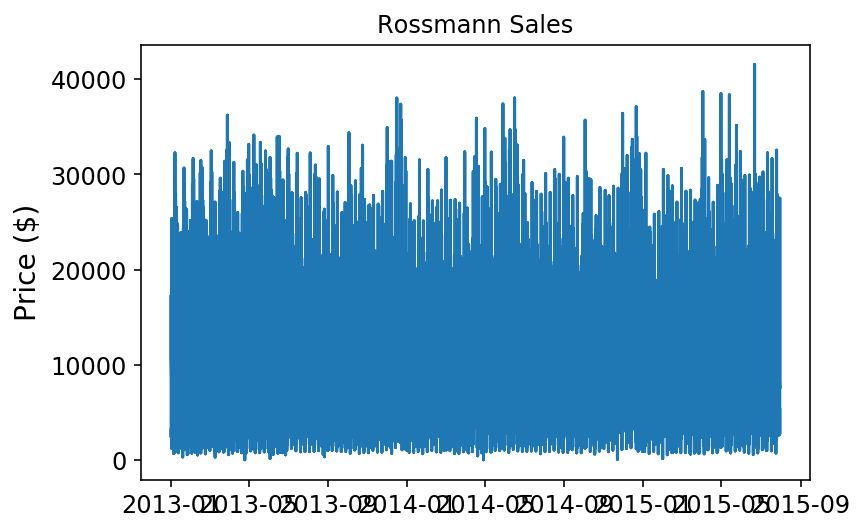

In [23]:
plt.plot(train.index, train['Sales'])
plt.title('Rossmann Sales')
plt.ylabel('Price ($)');
plt.show()

To clean up our graph, we want to form a new column which only accounts for the year of the sales. 

In [24]:
train['Year'] = train.index.year

# Take Dates from index and move to Date column 
train.reset_index(level=0, inplace = True)
train['sales'] = 0


Split the data into a train and test set. We use an 80/20 split. Then, we look to start are modein. 

test_store stands for the forecasting part. 

In [25]:
train_store=train[0:675472] 
test_store=train[675472:]

In [26]:
train_store.Date = pd.to_datetime(train_store.Date, format="%Y-%m-%d")
train_store.index = train_store.Date
test_store.Date = pd.to_datetime(test_store.Date, format="%Y-%m-%d")
test_store.index = test_store.Date

train_store = train_store.resample('D').mean()
train_store = train_store.interpolate(method='linear')

test_store = test_store.resample('D').mean()
test_store = test_store.interpolate(method='linear')

/Users/jasonkuruzovich/anaconda3/envs/tf2/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


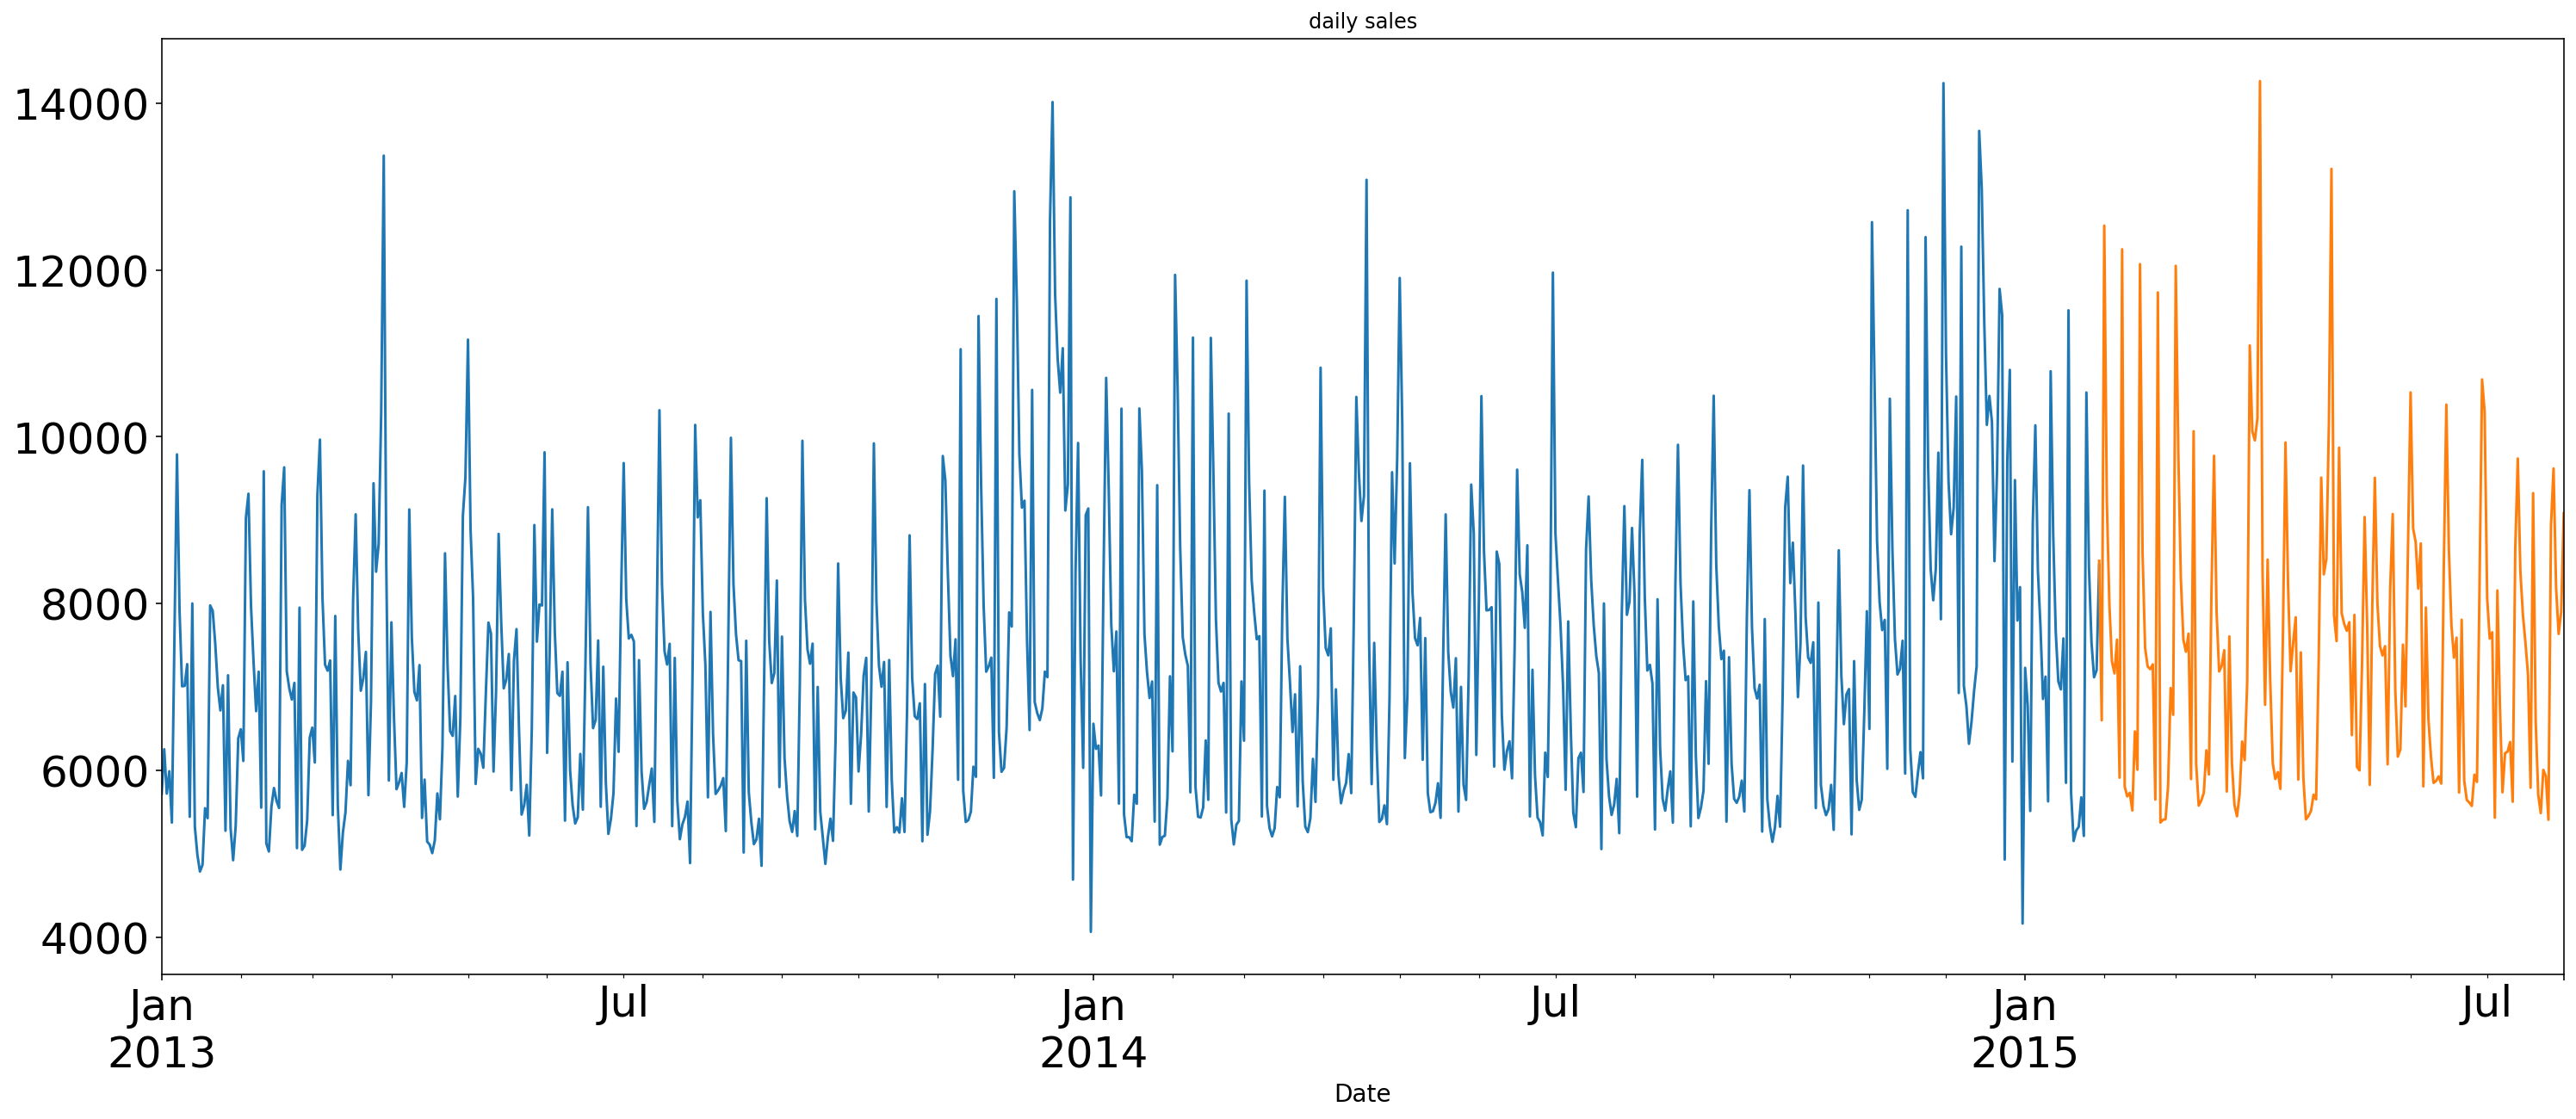

In [27]:
train_store.Sales.plot(figsize=(25,10), title='daily sales', fontsize=25)
test_store.Sales.plot()

Text(0.5,1,'Moving Average Forecast')

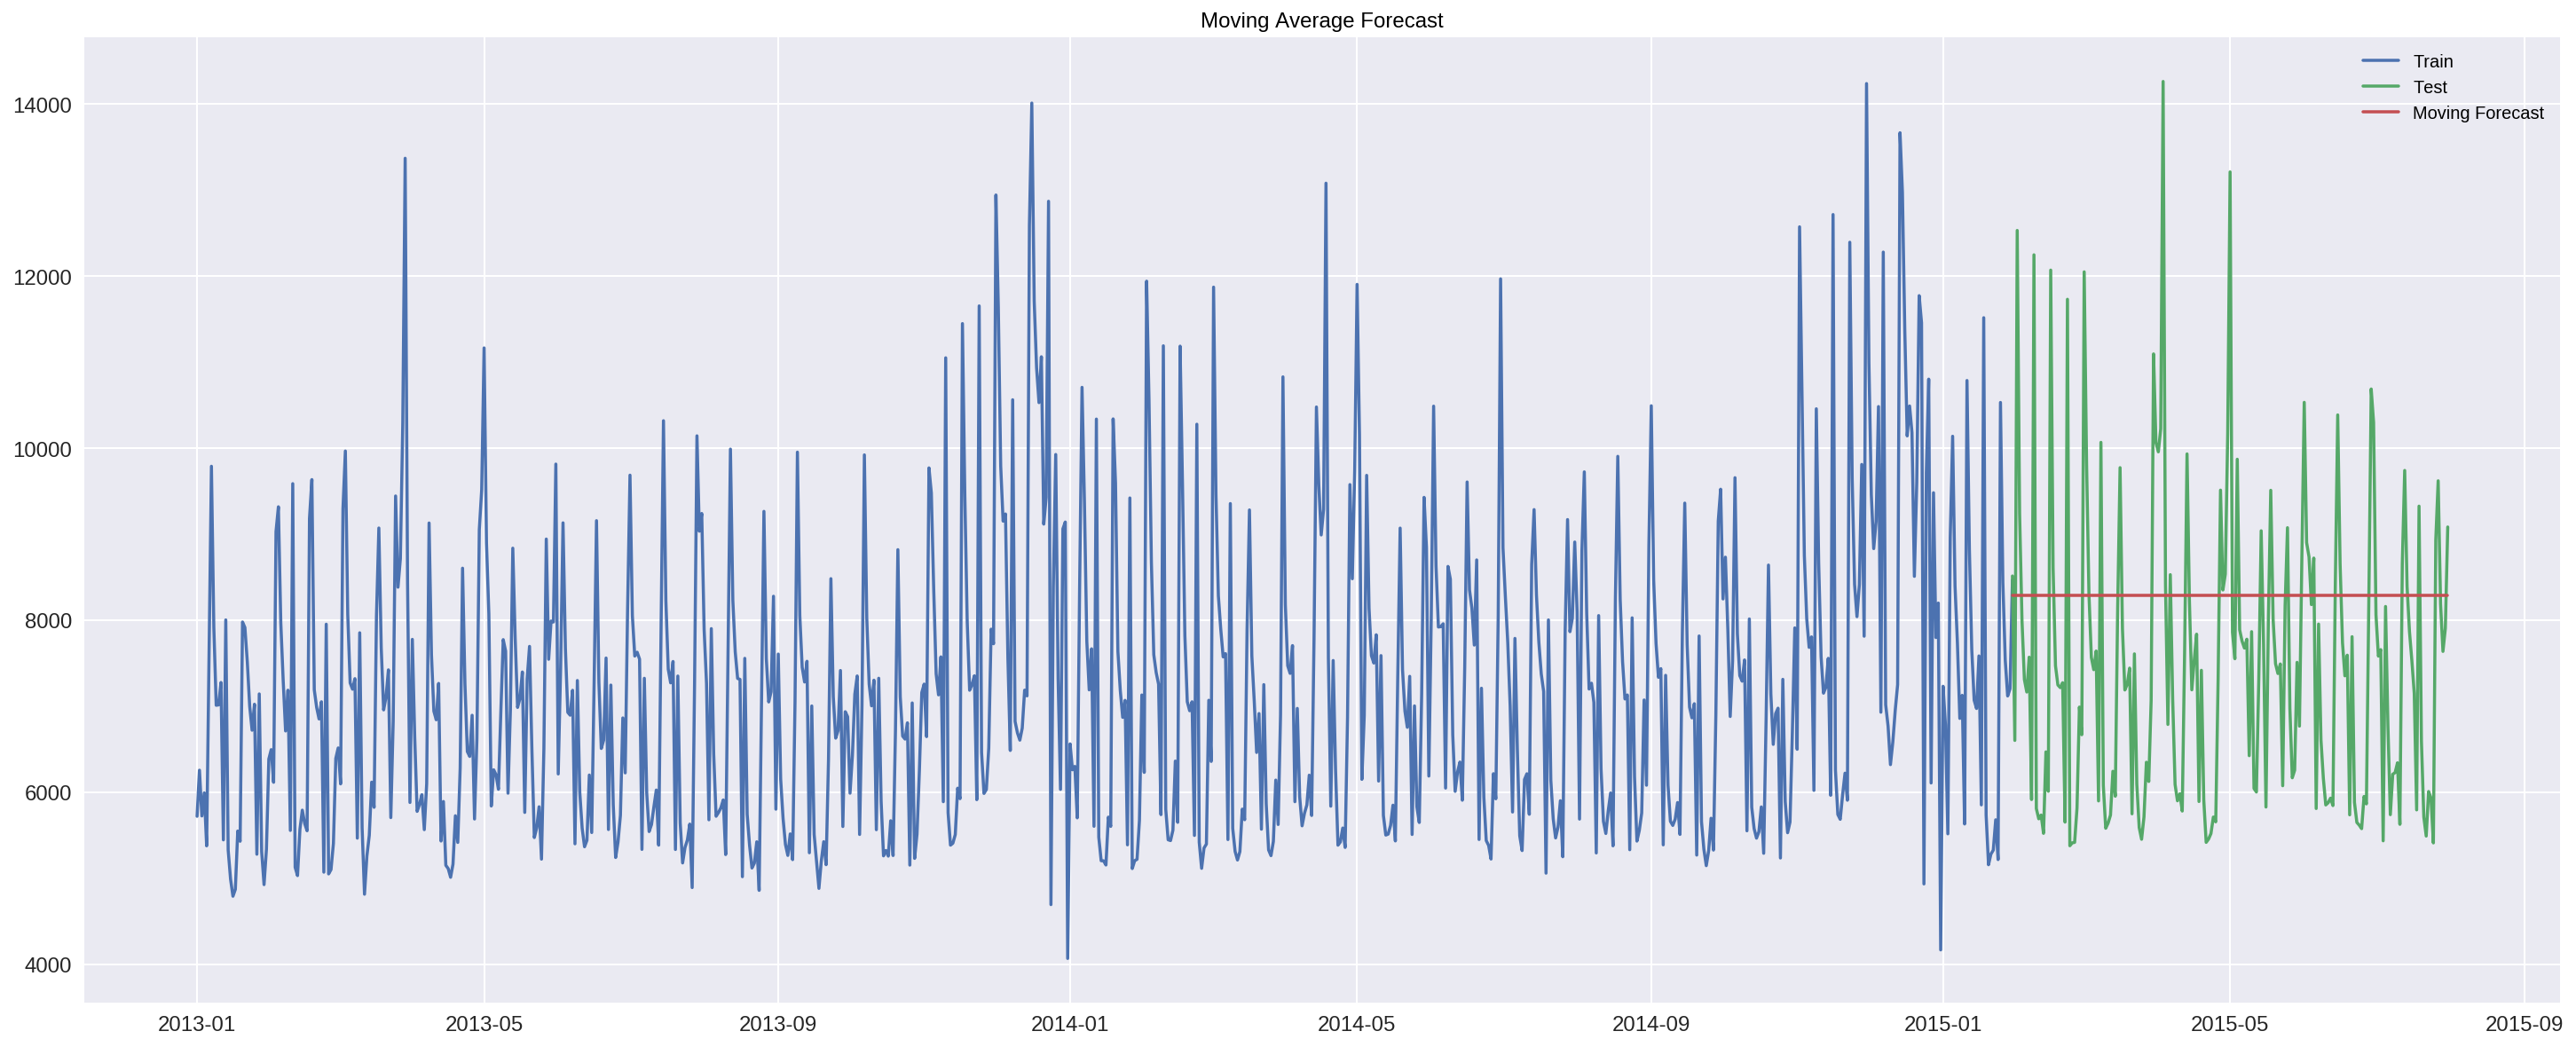

In [ ]:
y_hat_avg_moving = test_store.copy()
y_hat_avg_moving['moving_avg_forcast'] = train_store.Sales.rolling(90).mean().iloc[-1]
plt.figure(figsize=(25,10))
plt.plot(train_store['Sales'], label='Train')
plt.plot(test_store['Sales'], label='Test')
plt.plot(y_hat_avg_moving['moving_avg_forcast'], label='Moving Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecast')

In [ ]:
rms_avg_rolling = sqrt(mean_squared_error(test_store.Sales, y_hat_avg_moving.moving_avg_forcast))
print('ROLLING AVERAGE',rms_avg_rolling)

('ROLLING AVERAGE', 1915.886219620586)


The rolling average for our model is 1,915.88. This prediction seems to be very consistent in hitting the average of the future sales. This naive model definitely looks like a solid model, however, it is not the best one. 

## Facebook Prophet Model
- - - - - - - -  - - - - -- - - -
The Facebook Prophet package is designed to analyze time series data with daily observations, which can display patterns on different time scales. Prophet is optimized for business tasks with the following characteristics:

hourly, daily, or weekly observations with at least a few months (preferably a year) of history
strong multiple “human-scale” seasonalities: day of week and time of year
important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
a reasonable number of missing observations or large outliers
historical trend changes, for instance due to product launches or logging changes
trends that are non-linear growth curves, where a trend hits a natural limit or saturates
inspired by https://research.fb.com/prophet-forecasting-at-scale/

According to the "facebook research" website, there is four main component inside the facebook prophet model.

** A piecewise linear or logistic growth trend. 

** A yearly seasonal component modeled using Fourier series. 

** A weekly seasonal component using dummy variables.

** A user-provided list of important holidays.

The method of combing different models into one makes the facebook prophet model much more precise and flexible.

First of all, we will dealt with the data as same as the naive model

In [ ]:
store = pd.read_csv('https://raw.githubusercontent.com/RPI-DATA/tutorials-intro/master/rossmann-store-sales/rossmann-store-sales/store.csv', low_memory = False)



In [ ]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

train = train.dropna()

In [ ]:
sales = train[train.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [ ]:
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [ ]:
sales.head()

,ds,y
844339,2015-07-31,5263
842390,2015-07-30,5020
841366,2015-07-29,4782
840164,2015-07-28,5011
839140,2015-07-27,6102


Now, despite of the naive model, we will apply our sales set to the face book model by using the function `fbprophet`. `fbprophet.Prophet` can change the value of "changepoint_prior_scale" to 0.05 to achieve a better fit or to 0.15 to control how sensitive the trend is.

In [ ]:
sales_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
sales_prophet.fit(sales)

We will figure out the best forecasting by changing the value of changepoints.

If we find that our model is is fitting too closely to our training data (overfitting), our data will not be able to generalize new data.

If our model is not fitting closely enough to our training data (underfitting), our data has too much bias.

Underfitting: increase changepoint to allow more flexibility Overfitting: decrease changepoint to limit flexibili

In [ ]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(sales)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    sales[changepoint] = future['yhat']

We can now create the plot under all of the situation.

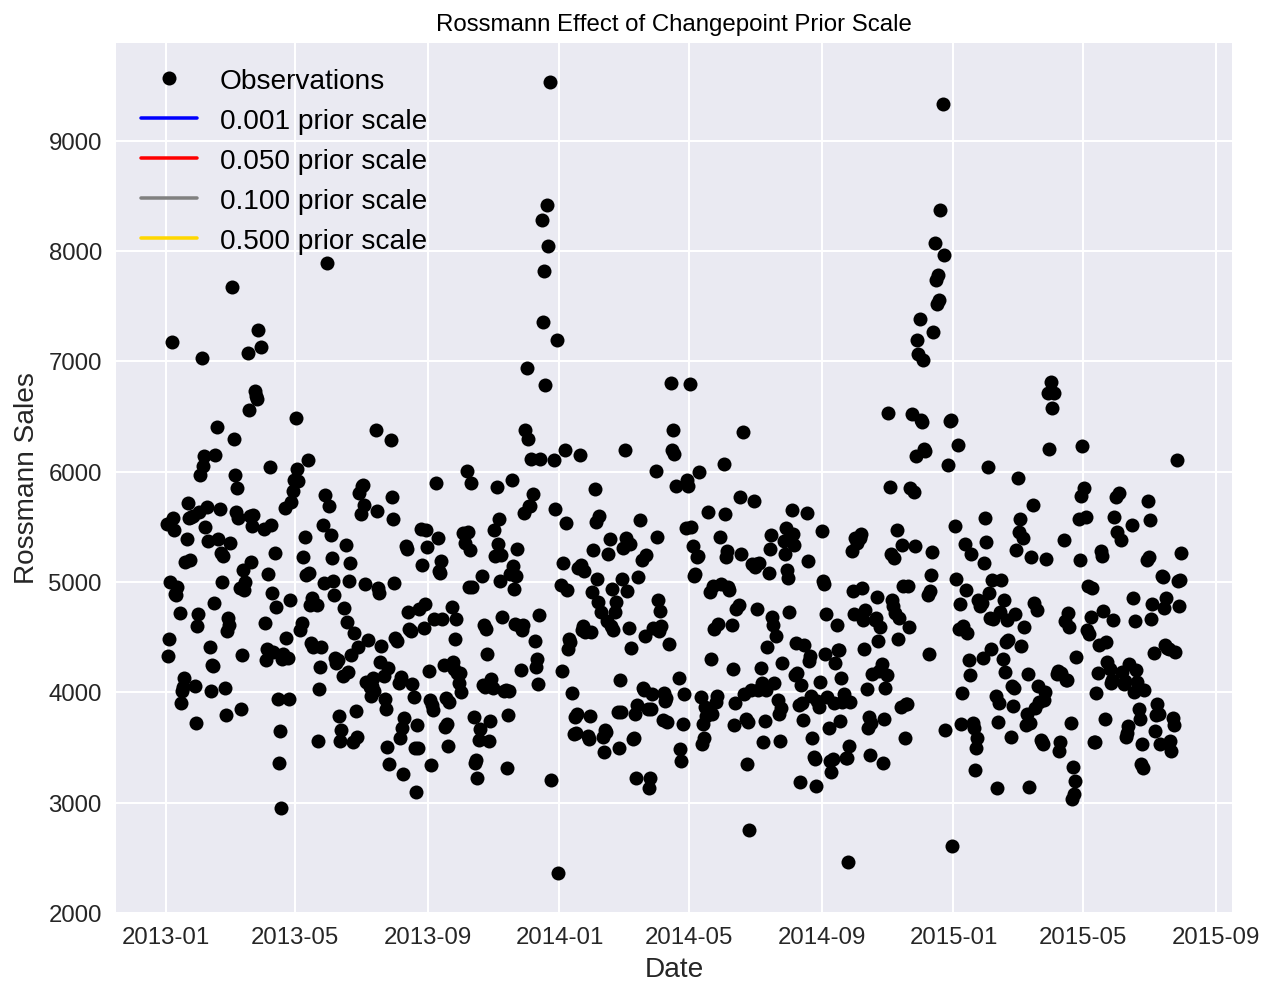

In [ ]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(sales['ds'], sales['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(sales['ds'], sales[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Rossmann Sales'); plt.title('Rossmann Effect of Changepoint Prior Scale');

Predictions for 6 Weeks
In order to make forecasts, we need to create a future dataframe. We need to specify the amount of future periods to predict and the frequency of our prediction.

Periods: 6 Weeks 

Frequency: Daily

In [ ]:
# Make a future dataframe for 6weeks
sales_forecast = sales_prophet.make_future_dataframe(periods=6*7, freq='D')
# Make predictions
sales_forecast = sales_prophet.predict(sales_forecast)

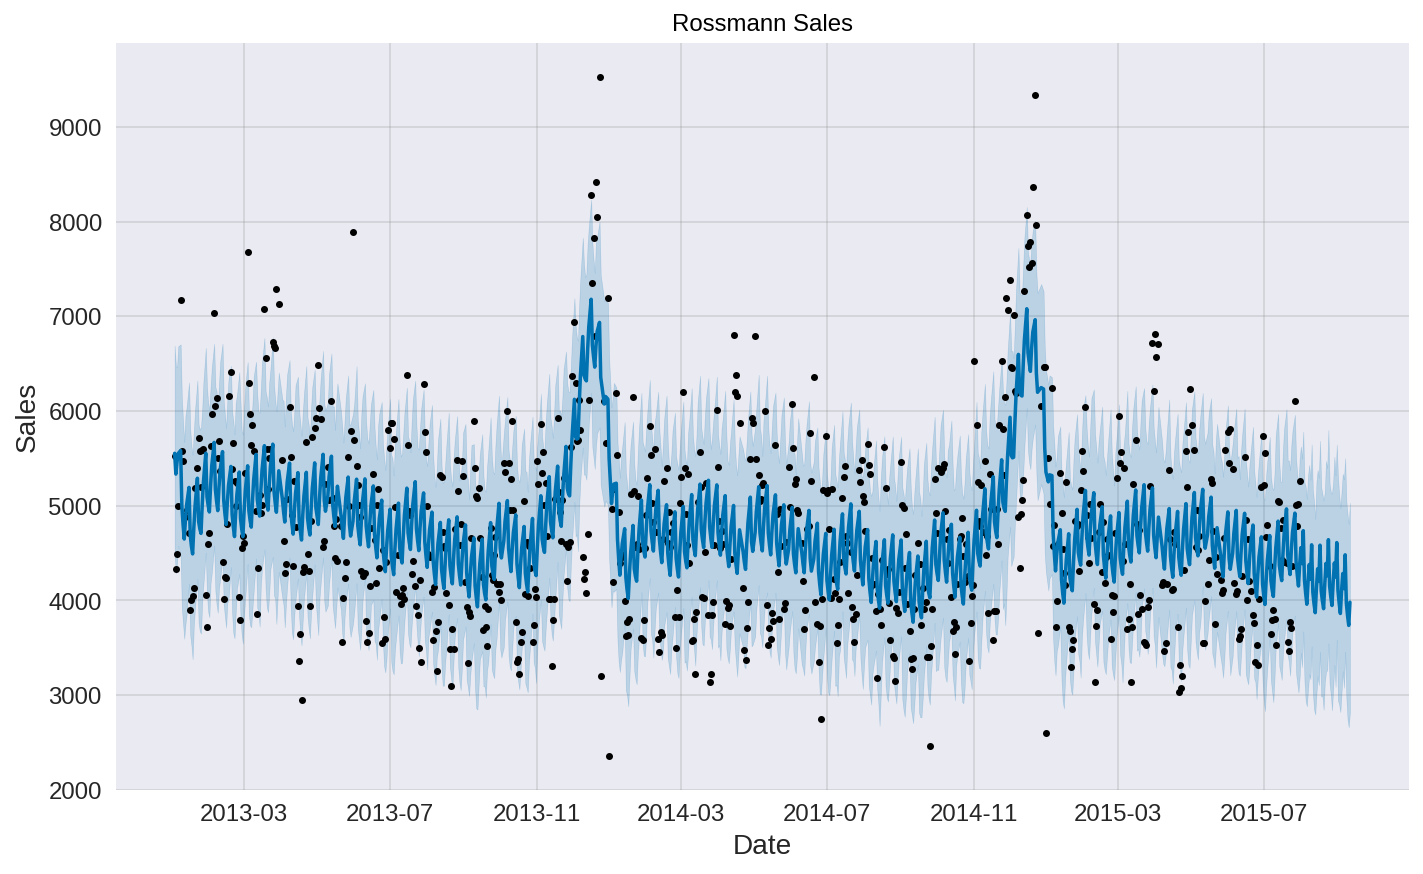

In [ ]:
sales_prophet.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Rossmann Sales');

In [ ]:
sales_prophet.changepoints[:10]

25    2013-01-31
50    2013-03-01
75    2013-04-02
100   2013-05-02
125   2013-06-04
150   2013-07-03
174   2013-07-31
199   2013-08-29
224   2013-09-27
249   2013-10-28
Name: ds, dtype: datetime64[ns]

We have listed out the most significant changepoints in our data. This is representing when the time series growth rate significantly changes.

## Conclusion
- -- - - - - - -  - - 
In this notebook, we made 2 different math model for the rossmann store sales dataset to forecast the future sales. Moving-average model brings us a basic understand of how the math model works, while facebook prophet model calculates the best solid result. Those math model will give us both of the rolling average and test model. 

## References
- - - -  - -  - - - - - - - - -
The dataset is the rossmann store sales dataset from kaggle:
https://www.kaggle.com/c/rossmann-store-sales

Facebook Prophet Documentation:
https://research.fb.com/prophet-forecasting-at-scale/



## Contributers

* nickespo21
* Linghao Dong
* Jose Figueroa